# AlgoTrading Curse Final project

# This notebook contains several main parts:
### 1. imports
### 2. Download Data from Yahoo Finance and employment data
### 3. Run statistics on the data
### 4. Clean Data with Noise
### 5. Clean Data with VIF Higher than 8
### 6. Forecast LSTM Model
### 7. Forecast ARIMA Model
### 8. Forecast Prophet Model
### 9. Summary of Model Performance

### Step 1: Import Required Libraries

In [1]:
#Installing yfinance library
!pip install yfinance

!pip install ta
!pip install prophet

  Using cached yfinance-0.2.61-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Using cached numpy-2.2.5-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached frozendict-2.4.6-py311-none-any.whl.metadata (23 kB)
  Using cached peewee-3.18.1.tar.gz (3.0 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached beautifulsoup4-4.13.4-py3-none-any.whl.metadata (3.8 kB)
  Using cached curl_cffi-0.11.1-cp39-abi3-win_amd64.whl.metadata (15 kB)


  DEPRECATION: Building 'ta' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'ta'. Discussion can be found at https://github.com/pypa/pip/issues/6334


  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached contourpy-1.3.2-cp311-cp311-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp311-cp311-win_amd64.whl.metadata (6.3 kB)
  Using cached pillow-11.2.1-cp311-cp311-win_amd64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
    --------------------------------------- 0.3/13.3 MB ? eta -:--:--
   -- ------------------------------------- 0.8/13.3 MB 2.4 MB/s eta 0:00:06
   ---- ----------------------------------- 1.6/13.3 MB 2.6 MB/s eta 0:00:05
   ------ --------------------------------- 2.1/13.3 MB 2.6 MB/s eta 0:00:05
   ------- -------------------------------- 2.6/13.3 MB 2.7 MB/s eta 0:00:05
   ---------- ----------------------------- 3.4/13.3 MB 2.8 M

In [5]:
import numpy as np
import pandas as pd
import requests
from io import StringIO
from datetime import datetime

import yfinance as yf

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

# Data preprocessing and evaluation
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Time series models and statistical analysis
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Deep learning models
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Financial indicators
from ta.momentum import RSIIndicator
from ta.trend import MACD

# Anomaly detection
from scipy.stats import zscore

# Forecasting
from prophet import Prophet
import pandas_datareader as pdr
from pandas_datareader import data as web
import datetime as dt

d:\studies\s8\algotrade\code\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### Step 2: Download Data from Yahoo Finance and employment data

In [41]:
leading_tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]
tickers = {
    'target_ticker': 'AAPL',        # המניה שברצונך לחזות
    'Nasdaq_100': 'QQQ',            # מדד מניות טכנולוגיה מובילות – הכי רלוונטי ל-AAPL
    'Finance_Sector': 'XLF',        # נותן הקשר לסקטור הפיננסי והמצב הכלכלי
    'Europe_Stocks': 'FEZ',         # חשיפה לאירופה (אפשר גם VGK)
    'Gold_ETF': 'GLD',              # אינדיקציה להעדפת סיכון / גידור אינפלציה
}

In [42]:
def download_data(tickers, start='2020-01-01', end='2025-04-01'):
	"""
	Download stock data from Yahoo Finance for multiple tickers.
	"""
	stock_data = pd.DataFrame()
	for name, ticker in tickers.items():
		data = yf.download(ticker, start=start, end=end)
		stock_data[name] = data['Close']
		# if 'Adj Close' in data.columns:
		# 	stock_data[name] = data['Adj Close']
		# else:
		# 	print(f"Warning: 'Adj Close' not found for {ticker}. Available columns: {data.columns}")
		# 	# Use Close price if Adj Close is not available
		# 	stock_data[name] = data['Close']
	return stock_data


In [44]:
def get_and_prepare_unemployment_data():
    """
    Download U.S. unemployment rate data (UNRATE) from FRED,
    resample to daily frequency, and interpolate linearly.
    """
    url = "https://fred.stlouisfed.org/graph/fredgraph.csv?id=UNRATE"
    response = requests.get(url)
    
    if response.status_code != 200:
        raise Exception("Failed to download unemployment data from FRED.")

    data = StringIO(response.text)
    # print()
    unemployment_data = pd.read_csv(data, parse_dates=['observation_date'], index_col='observation_date')

    unemployment_data.columns = ['UNRATE']
    unemployment_data['Unemployment Rate'] =  unemployment_data['UNRATE'] # Convert to decimal format

    # unemployment_data = unemployment_data.resample("D").interpolate(method='linear')

    return unemployment_data

In [45]:
# Testing the function with our predefined tickers
tickers_data = download_data(tickers)
tickers_data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,target_ticker,Nasdaq_100,Finance_Sector,Europe_Stocks,Gold_ETF
Date,,,,,
2020-01-02,72.620834,209.325882,28.069832,35.734081,143.949997
2020-01-03,71.914818,207.408463,27.771791,35.275063,145.860001
2020-01-06,72.487854,208.744858,27.753733,35.335693,147.389999
2020-01-07,72.146950,208.715836,27.573105,35.136494,147.970001
2020-01-08,73.307503,210.284607,27.753733,35.309696,146.860001
...,...,...,...,...,...
2025-03-25,223.456970,493.459991,50.430000,56.410000,278.470001
2025-03-26,221.239868,484.380005,50.279999,55.320000,278.239990
2025-03-27,223.556839,481.619995,50.180000,55.279999,281.970001


In [46]:
employment_data = get_and_prepare_unemployment_data()
employment_data

,UNRATE,Unemployment Rate
observation_date,,
1948-01-01,3.4,3.4
1948-02-01,3.8,3.8
1948-03-01,4.0,4.0
1948-04-01,3.9,3.9
1948-05-01,3.5,3.5
...,...,...
2024-12-01,4.1,4.1
2025-01-01,4.0,4.0
2025-02-01,4.1,4.1


In [47]:
# First, add year and month columns to both dataframes
tickers_data['year'] = tickers_data.index.year
tickers_data['month'] = tickers_data.index.month
employment_data['year'] = employment_data.index.year
employment_data['month'] = employment_data.index.month

# The employment data is already monthly, so we can use it directly
# Merge based on year and month
merged_df = pd.merge(
    tickers_data,
    employment_data[['Unemployment Rate', 'year', 'month']],  # Select only needed columns
    on=['year', 'month'],
    how='left'
)

# Preserve the original index from tickers_data
merged_df.index = tickers_data.index

# Drop the temporary columns used for merging
merged_df = merged_df.drop(columns=['year', 'month'])

# Display the first few rows to verify the merge worked correctly
merged_df

,target_ticker,Nasdaq_100,Finance_Sector,Europe_Stocks,Gold_ETF,Unemployment Rate
Date,,,,,,
2020-01-02,72.620834,209.325882,28.069832,35.734081,143.949997,3.6
2020-01-03,71.914818,207.408463,27.771791,35.275063,145.860001,3.6
2020-01-06,72.487854,208.744858,27.753733,35.335693,147.389999,3.6
2020-01-07,72.146950,208.715836,27.573105,35.136494,147.970001,3.6
2020-01-08,73.307503,210.284607,27.753733,35.309696,146.860001,3.6
...,...,...,...,...,...,...
2025-03-25,223.456970,493.459991,50.430000,56.410000,278.470001,4.2
2025-03-26,221.239868,484.380005,50.279999,55.320000,278.239990,4.2
2025-03-27,223.556839,481.619995,50.180000,55.279999,281.970001,4.2


In [48]:
def add_technical_indicators(df):
    """
    Add RSI and MACD indicators to the DataFrame.
    """
    # Initialize the RSI and MACD indicators
    rsi_indicator = RSIIndicator(df['target_ticker'])
    macd_indicator = MACD(df['target_ticker'])

    # Calculate RSI and MACD
    df['RSI'] = rsi_indicator.rsi()
    df['MACD'] = macd_indicator.macd() # Moving Average Convergence Divergence
    df['MACD Signal'] = macd_indicator.macd_signal()
    df['MACD Histogram'] = macd_indicator.macd_diff()

    return df

In [49]:
final_merged_df = add_technical_indicators(merged_df)
final_merged_df

,target_ticker,Nasdaq_100,Finance_Sector,Europe_Stocks,Gold_ETF,Unemployment Rate,RSI,MACD,MACD Signal,MACD Histogram
Date,,,,,,,,,,
2020-01-02,72.620834,209.325882,28.069832,35.734081,143.949997,3.6,NaN,NaN,NaN,NaN
2020-01-03,71.914818,207.408463,27.771791,35.275063,145.860001,3.6,NaN,NaN,NaN,NaN
2020-01-06,72.487854,208.744858,27.753733,35.335693,147.389999,3.6,NaN,NaN,NaN,NaN
2020-01-07,72.146950,208.715836,27.573105,35.136494,147.970001,3.6,NaN,NaN,NaN,NaN
2020-01-08,73.307503,210.284607,27.753733,35.309696,146.860001,3.6,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-03-25,223.456970,493.459991,50.430000,56.410000,278.470001,4.2,47.182569,-5.148234,-5.245100,0.096866
2025-03-26,221.239868,484.380005,50.279999,55.320000,278.239990,4.2,44.768944,-4.695809,-5.135242,0.439433
2025-03-27,223.556839,481.619995,50.180000,55.279999,281.970001,4.2,47.775584,-4.103001,-4.928794,0.825792


In [50]:
# Count and display missing values in the DataFrame before removing them
missing_values = final_merged_df.isna().sum()
missing_percent = (missing_values / len(final_merged_df)) * 100
missing_stats = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percent
})

# Display results
print("Missing Values Summary:")
print(missing_stats[missing_stats['Missing Values'] > 0])  # Only show columns with missing values
print(f"\nTotal rows in dataset: {len(final_merged_df)}")
print(f"Rows with at least one missing value: {final_merged_df.isna().any(axis=1).sum()}")
print(f"Percentage of rows with missing values: {final_merged_df.isna().any(axis=1).sum() / len(final_merged_df) * 100:.2f}%")

Missing Values Summary:
                Missing Values  Percentage (%)
RSI                         13        0.986343
MACD                        25        1.896813
MACD Signal                 33        2.503794
MACD Histogram              33        2.503794

Total rows in dataset: 1318
Rows with at least one missing value: 33
Percentage of rows with missing values: 2.50%


In [51]:
final_merged_df = final_merged_df[~final_merged_df.isna().any(axis=1)]  # Check for NaN values
final_merged_df

,target_ticker,Nasdaq_100,Finance_Sector,Europe_Stocks,Gold_ETF,Unemployment Rate,RSI,MACD,MACD Signal,MACD Histogram
Date,,,,,,,,,,
2020-02-20,77.628296,227.357208,28.060804,34.885326,152.410004,3.5,53.041443,0.843615,0.950529,-0.106914
2020-02-21,75.871162,222.989777,27.789854,34.660145,154.699997,3.5,46.139515,0.625895,0.885602,-0.259707
2020-02-24,72.267265,214.390533,26.886711,33.161842,156.089996,3.5,35.838919,0.160695,0.740621,-0.579926
2020-02-25,69.819397,208.560883,25.974527,32.313099,153.300003,3.5,30.807942,-0.400882,0.512320,-0.913202
2020-02-26,70.927017,209.635773,25.784866,32.321762,153.970001,3.5,35.237960,-0.747938,0.260269,-1.008206
...,...,...,...,...,...,...,...,...,...,...
2025-03-25,223.456970,493.459991,50.430000,56.410000,278.470001,4.2,47.182569,-5.148234,-5.245100,0.096866
2025-03-26,221.239868,484.380005,50.279999,55.320000,278.239990,4.2,44.768944,-4.695809,-5.135242,0.439433
2025-03-27,223.556839,481.619995,50.180000,55.279999,281.970001,4.2,47.775584,-4.103001,-4.928794,0.825792


In [52]:
# Count and display missing values in the DataFrame before removing them
missing_values = final_merged_df.isna().sum()
missing_percent = (missing_values / len(final_merged_df)) * 100
missing_stats = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percent
})

# Display results
print("Missing Values Summary:")
print(missing_stats[missing_stats['Missing Values'] > 0])  # Only show columns with missing values
print(f"\nTotal rows in dataset: {len(final_merged_df)}")
print(f"Rows with at least one missing value: {final_merged_df.isna().any(axis=1).sum()}")
print(f"Percentage of rows with missing values: {final_merged_df.isna().any(axis=1).sum() / len(final_merged_df) * 100:.2f}%")

Missing Values Summary:
Empty DataFrame
Columns: [Missing Values, Percentage (%)]
Index: []

Total rows in dataset: 1285
Rows with at least one missing value: 0
Percentage of rows with missing values: 0.00%


### Step 3: Run statistics on the data

In [53]:
# Basic statistics: min, max, mean, etc.
summary_stats = final_merged_df.describe()
print("Summary Statistics:\n", summary_stats)

Summary Statistics:
        target_ticker   Nasdaq_100  Finance_Sector  Europe_Stocks     Gold_ETF  \
count    1285.000000  1285.000000     1285.000000    1285.000000  1285.000000   
mean      157.624164   350.336520       34.162257      40.817488   185.642786   
std        42.985577    83.427364        7.546924       7.206671    29.031321   
min        54.378586   163.947403       16.084833      21.816322   138.039993   
25%       130.263977   288.504547       30.823105      35.259434   167.160004   
50%       154.952423   339.374725       33.946133      41.391335   176.979996   
75%       182.756256   395.387207       37.762840      45.280323   187.869995   
max       258.396667   538.716675       52.001118      57.300247   288.140015   

       Unemployment Rate          RSI         MACD  MACD Signal  \
count        1285.000000  1285.000000  1285.000000  1285.000000   
mean            4.955175    54.042060     0.822526     0.839687   
std             2.302362    12.257664     2.8762

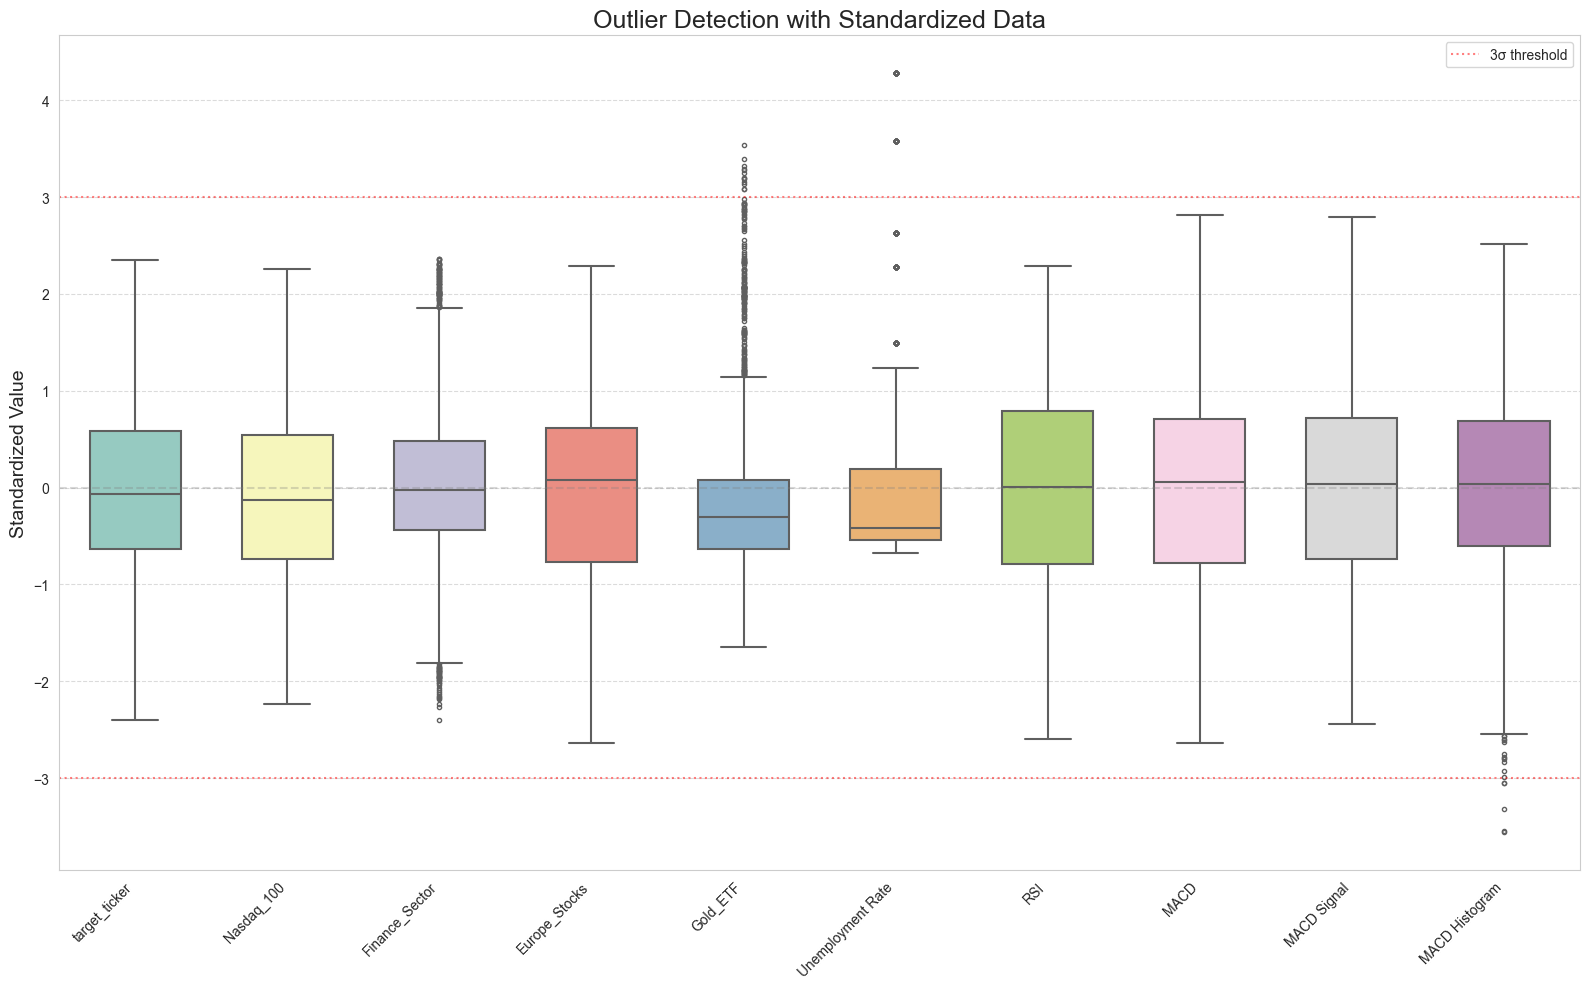

In [57]:
# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_merged_df)

# Create a DataFrame with the scaled data to preserve column names
scaled_df = pd.DataFrame(scaled_data, columns=final_merged_df.columns, index=final_merged_df.index)

# Enhanced visual detection of outliers using a boxplot with seaborn
plt.figure(figsize=(16, 10))
sns.set_style("whitegrid")  # Set the seaborn style

# Create the boxplot with enhanced styling
ax = sns.boxplot(
    data=scaled_df,
    palette="Set3",        # Use a colorful palette
    width=0.6,             # Adjust box width
    fliersize=3,           # Size of outlier points
    linewidth=1.5          # Width of the box lines
)

# Improve the plot appearance
plt.title('Outlier Detection with Standardized Data', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('Standardized Value', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a horizontal line at 0
plt.axhline(y=0, color='grey', linestyle='--', alpha=0.3)

# Add a reference for potential outliers
plt.axhline(y=3, color='red', linestyle=':', alpha=0.5, label="3σ threshold")
plt.axhline(y=-3, color='red', linestyle=':', alpha=0.5)

plt.legend()
plt.tight_layout()
plt.show()

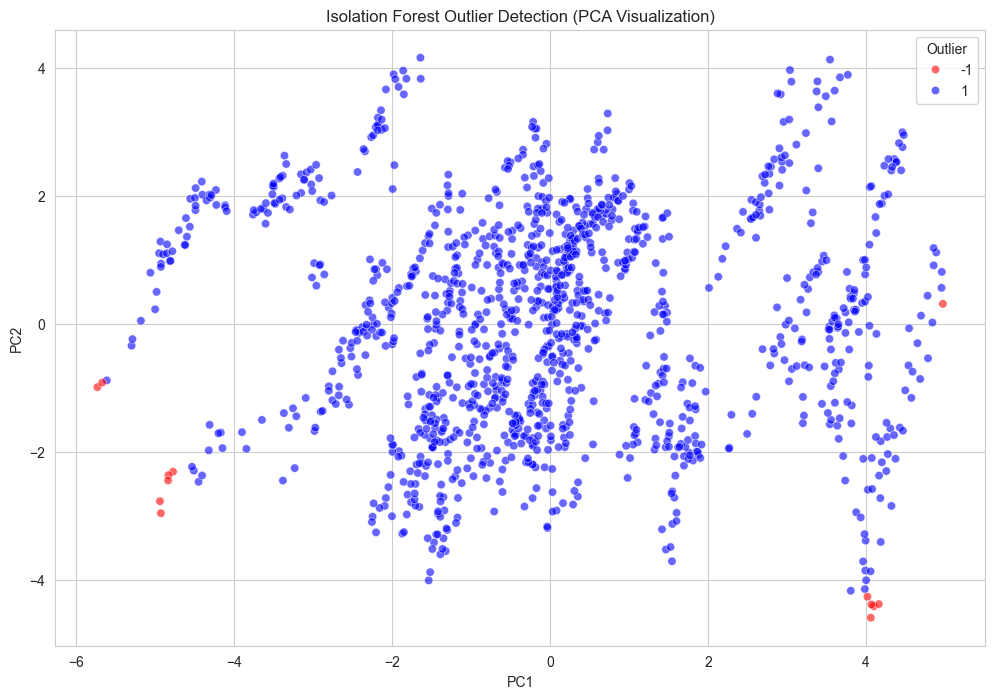

In [58]:
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
# Run Isolation Forest
iso = IsolationForest(contamination=0.01, random_state=42)
outlier_flags = iso.fit_predict(scaled_df)  # -1 = outlier, 1 = inlier

# Add labels to the DataFrame
scaled_df['Outlier'] = outlier_flags

# Project to 2D using PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_df.drop(columns='Outlier'))

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=scaled_df.index)
pca_df['Outlier'] = scaled_df['Outlier']

plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Outlier', palette={1: 'blue', -1: 'red'}, alpha=0.6)
plt.title("Isolation Forest Outlier Detection (PCA Visualization)")
plt.legend(title='Outlier', loc='upper right')
plt.grid(True)
plt.show()

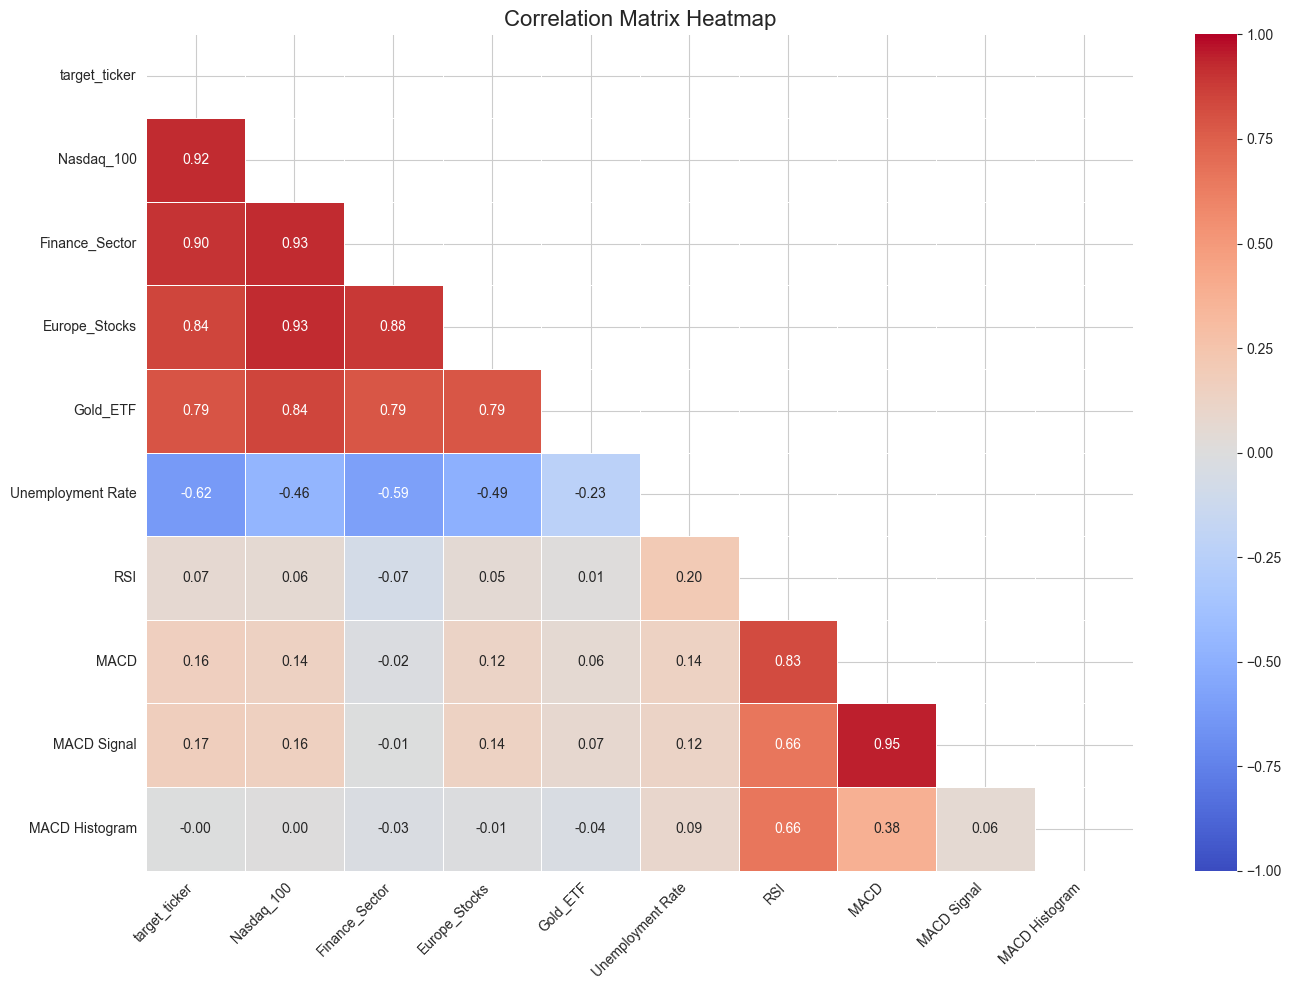

In [59]:
# Compute correlation between all variables
correlation_matrix = final_merged_df.corr()

# Enhanced visualization of the correlation matrix
plt.figure(figsize=(14, 10))
mask = np.triu(correlation_matrix)  # Create a mask for the upper triangle
sns.heatmap(
    correlation_matrix,
    annot=True,           # Show values in cells
    cmap='coolwarm',      # Color scheme
    fmt='.2f',            # Format numbers to 2 decimal places
    linewidths=0.5,       # Add line width between cells
    mask=mask,            # Apply the mask to show only lower triangle
    vmin=-1, vmax=1       # Fix the scale from -1 to 1
)
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()        # Adjust layout to make room for labels
plt.show()

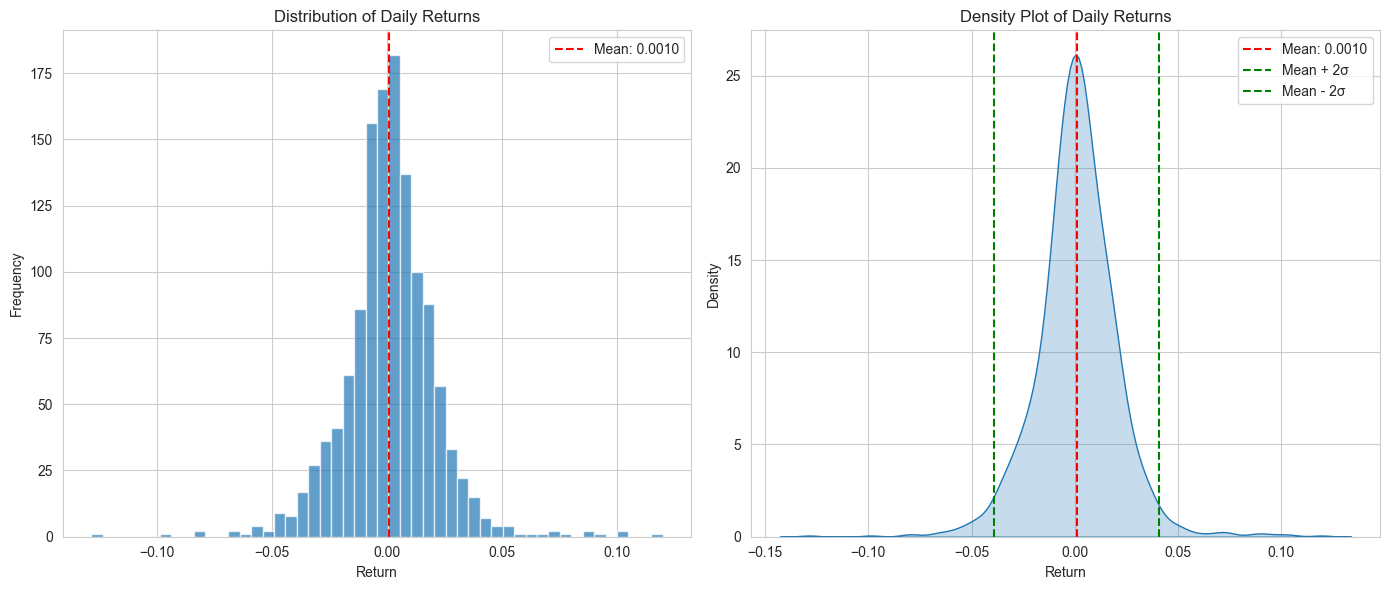

Average daily return: 0.0010 (0.10%)
Standard deviation of returns: 0.0200 (2.00%)
Probability of positive return: 0.5296 (52.96%)
Probability of negative return: 0.4673 (46.73%)


In [60]:
# Statistical Analysis on Returns
# Let's analyze the daily returns to understand risk characteristics

# Calculate daily returns
returns = final_merged_df['target_ticker'].pct_change()
returns = returns.dropna()

# Basic statistics of returns
mean_return = returns.mean()
std_return = returns.std()

# Calculate probabilities
prob_positive_return = (returns > 0).mean()
prob_negative_return = (returns < 0).mean()

# Plot returns distribution
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
returns.hist(bins=50, alpha=0.7)
plt.axvline(x=mean_return, color='r', linestyle='--', label=f'Mean: {mean_return:.4f}')
plt.title('Distribution of Daily Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
sns.kdeplot(returns, fill=True)
plt.axvline(x=mean_return, color='r', linestyle='--', label=f'Mean: {mean_return:.4f}')
plt.axvline(x=mean_return + 2*std_return, color='g', linestyle='--', label=f'Mean + 2σ')
plt.axvline(x=mean_return - 2*std_return, color='g', linestyle='--', label=f'Mean - 2σ')
plt.title('Density Plot of Daily Returns')
plt.xlabel('Return')
plt.legend()

plt.tight_layout()
plt.show()

# Print statistical findings
print(f"Average daily return: {mean_return:.4f} ({mean_return*100:.2f}%)")
print(f"Standard deviation of returns: {std_return:.4f} ({std_return*100:.2f}%)")
print(f"Probability of positive return: {prob_positive_return:.4f} ({prob_positive_return*100:.2f}%)")
print(f"Probability of negative return: {prob_negative_return:.4f} ({prob_negative_return*100:.2f}%)")

In [64]:
import xgboost as xgb
import time
from sklearn.model_selection import train_test_split

In [65]:

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error

    Args:
        y_true: True values
        y_pred: Predicted values

    Returns:
        MAPE value (percentage)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

In [67]:
def run_model(xgb_params, X_train, y_train, X_test, y_test):
    print("\nTraining XGBoost model...")
    xgb_model = xgb.XGBRegressor(**xgb_params)

    # Start timing the training
    training_start_time = time.time()

    results_log = {}
    feature_importances = {}


    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

    # Train the model
    xgb_model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=100
    )

    print(f"\nTesting on window number {i + 1}...")    # Make predictions
    predictions = xgb_model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    # mae = mean_absolute_error(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)

    results_log = {'mes': mse, 'rmse': rmse, 'mape': mape}
    feature_importances = xgb_model.feature_importances_


    training_time = time.time() - training_start_time
    print(f"\nCompleted in {training_time:.2f} seconds")
    
    return results_log, feature_importances

In [ ]:
direct_results, direct_feature_importances = run_direct(xgb_params, direct_splits)

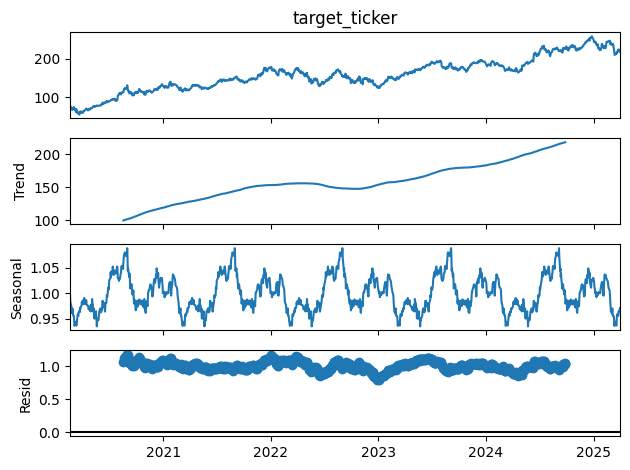

In [124]:
# 1. Seasonal Decomposition (Trend, Seasonal, Residual)
decomposition = seasonal_decompose(final_merged_df['target_ticker'], model='multiplicative', period=252) # Assuming daily data with 252 trading days per year
decomposition.plot()
plt.show()

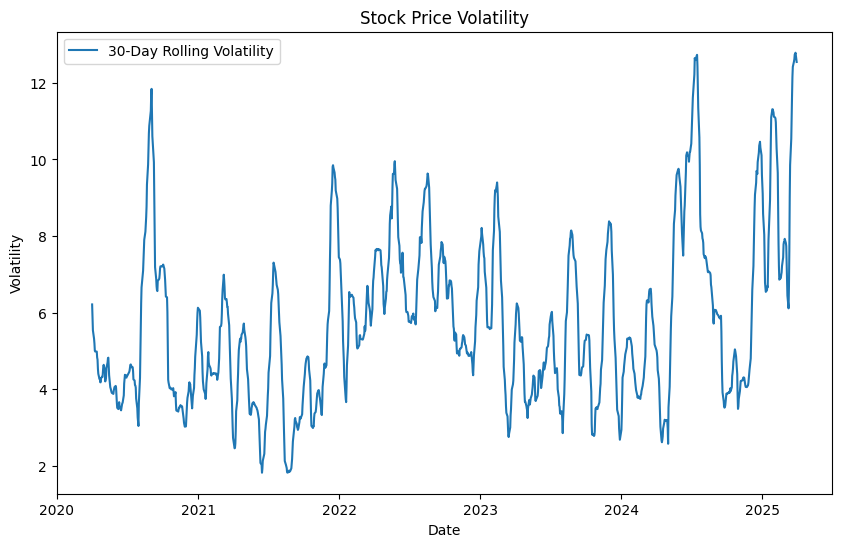

In [125]:
# 2. Volatility (Rolling Standard Deviation)
volatility = final_merged_df['target_ticker'].rolling(window=30).std() # 30-day rolling window
plt.figure(figsize=(10, 6))
plt.plot(volatility, label='30-Day Rolling Volatility')
plt.title('Stock Price Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

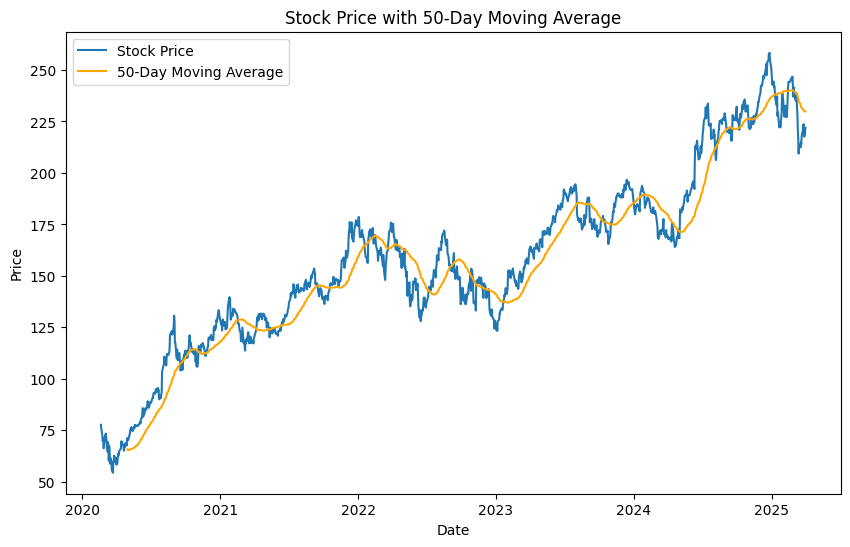

In [126]:
# 3. Trend Visualization with Moving Average
moving_average = final_merged_df['target_ticker'].rolling(window=50).mean() # 50-day moving average
plt.figure(figsize=(10, 6))
plt.plot(final_merged_df['target_ticker'], label='Stock Price')
plt.plot(moving_average, label='50-Day Moving Average', color='orange')
plt.title('Stock Price with 50-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [127]:
# 4. Stationarity Test (Augmented Dickey-Fuller Test)
result = adfuller(final_merged_df['target_ticker'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.424776
p-value: 0.570342
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


<Figure size 1000x600 with 0 Axes>

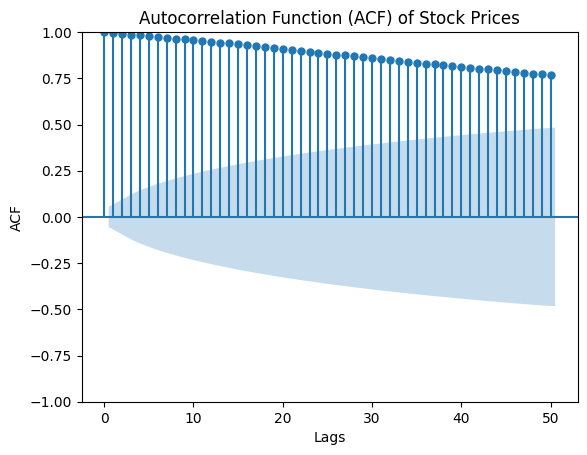

In [128]:
# 5. Autocorrelation Analysis (ACF Plot)
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 6))
plot_acf(final_merged_df['target_ticker'].dropna(), lags=50)
plt.title('Autocorrelation Function (ACF) of Stock Prices')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

### Step 4: Clean Data with Noise

In [129]:
# 1. Remove missing values
combined_data = final_merged_df.dropna()

# 2. Remove outliers using a more lenient method
def remove_outliers(df, column, threshold=5):
    """
    Remove outliers using z-score.

    Parameters:
    - df: DataFrame
    - column: Column name to check for outliers
    - threshold: Z-score threshold to consider a value as an outlier

    Returns:
    - DataFrame with outliers removed
    """
    # Calculate z-scores for the specified column
    df['zscore'] = zscore(df[column])
    # Filter out rows where the absolute z-score is above the threshold
    df_filtered = df[np.abs(df['zscore']) < threshold]
    # Drop the zscore column used for filtering
    df_filtered = df_filtered.drop(columns=['zscore'])

    return df_filtered

# Apply the outlier removal function to each numeric column in the DataFrame
for column in combined_data.columns:
    if pd.api.types.is_numeric_dtype(combined_data[column]):
        combined_data = remove_outliers(combined_data, column, threshold=5)  # Adjust threshold as needed

### Step 5: Clean Data with VIF Higher than 8

In [16]:
print(combined_data)

            target_ticker     Dow_Jones  MSCI_ACWI  Treasury_Bond_ETF  \
Date                                                                    
2015-02-20      29.018137  18140.439453  35.156055         105.202766   
2015-02-23      29.802414  18116.839844  34.984985         105.451302   
2015-02-24      29.616425  18209.189453  35.249367         105.862572   
2015-02-25      28.859035  18224.570312  35.280472         105.905441   
2015-02-26      29.224281  18214.419922  35.202721         105.494118   
...                   ...           ...        ...                ...   
2024-06-18     214.289993  38834.859375  53.200001         115.268532   
2024-06-20     209.679993  39134.761719  53.200001         115.129272   
2024-06-21     207.490005  39150.328125  52.889999         115.149170   
2024-06-24     208.139999  39411.210938  53.240002         115.179008   
2024-06-25     209.070007  39112.160156  53.290001         115.248642   

            tech_index  finance_index  european_in

In [17]:
# Function to calculate VIF
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data['feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Function to remove features with VIF > 8
def remove_high_vif_features(df, threshold=8):
    ticker_column = df['target_ticker']
    df = df.drop(columns=['target_ticker'])

    while True:
        vif_data = calculate_vif(df)
        print(vif_data['VIF'])
        max_vif = vif_data['VIF'].max()
        if max_vif > threshold:
            feature_to_remove = vif_data.loc[vif_data['VIF'] == max_vif, 'feature'].values[0]
            print(f"Removing {feature_to_remove} with VIF {max_vif}")
            df = df.drop(columns=[feature_to_remove])
        else:
            break

    df.insert(0, 'target_ticker', ticker_column)
    return df

# Calculate percentage change and remove rows with NaN values
# combined_data_pct = combined_data.pct_change() * 100
# combined_data_pct['target_ticker'] = combined_data['target_ticker']
# combined_data_pct = combined_data_pct.dropna()

# Removing high VIF features
# cleaned_data = remove_high_vif_features(combined_data_pct)
cleaned_data = remove_high_vif_features(combined_data)


# Display the shape and the first few rows of the cleaned data
print(cleaned_data.shape)
print(cleaned_data.head())


0     1169.623114
1     2796.469184
2      704.518389
3      144.642653
4      610.857153
5     2568.465328
6      662.795681
7       42.732522
8             inf
9             inf
10            inf
Name: VIF, dtype: float64
Removing MACD with VIF inf


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


0    1169.623114
1    2796.469184
2     704.518389
3     144.642653
4     610.857153
5    2568.465328
6     662.795681
7      42.732522
8       2.122178
9       1.519706
Name: VIF, dtype: float64
Removing MSCI_ACWI with VIF 2796.469184037579
0    991.858539
1    410.822117
2     73.587560
3    610.579127
4    435.442827
5    378.419598
6     42.386733
7      2.096294
8      1.519020
Name: VIF, dtype: float64
Removing Dow_Jones with VIF 991.8585394831974
0    299.730278
1     53.351216
2    234.961981
3    435.020599
4    372.371869
5     42.110162
6      2.092986
7      1.514769
Name: VIF, dtype: float64
Removing european_index with VIF 435.02059911967063
0    287.568519
1     50.728851
2    137.388343
3    331.009623
4     41.915481
5      1.948087
6      1.508766
Name: VIF, dtype: float64
Removing Employment-Population Ratio with VIF 331.009623498828
0     59.484502
1     39.212077
2    111.545497
3     40.219630
4      1.835956
5      1.499177
Name: VIF, dtype: float64
Removing fina

### Step 6: Forecast Model LSTM


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2162/2162 ━━━━━━━━━━━━━━━━━━━━ 132s 58ms/step - loss: 0.0054
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step
LSTM RMSE: 10.150903429481815
LSTM R^2: 0.31670813392719466


<ipython-input-18-c398a0b3e306>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


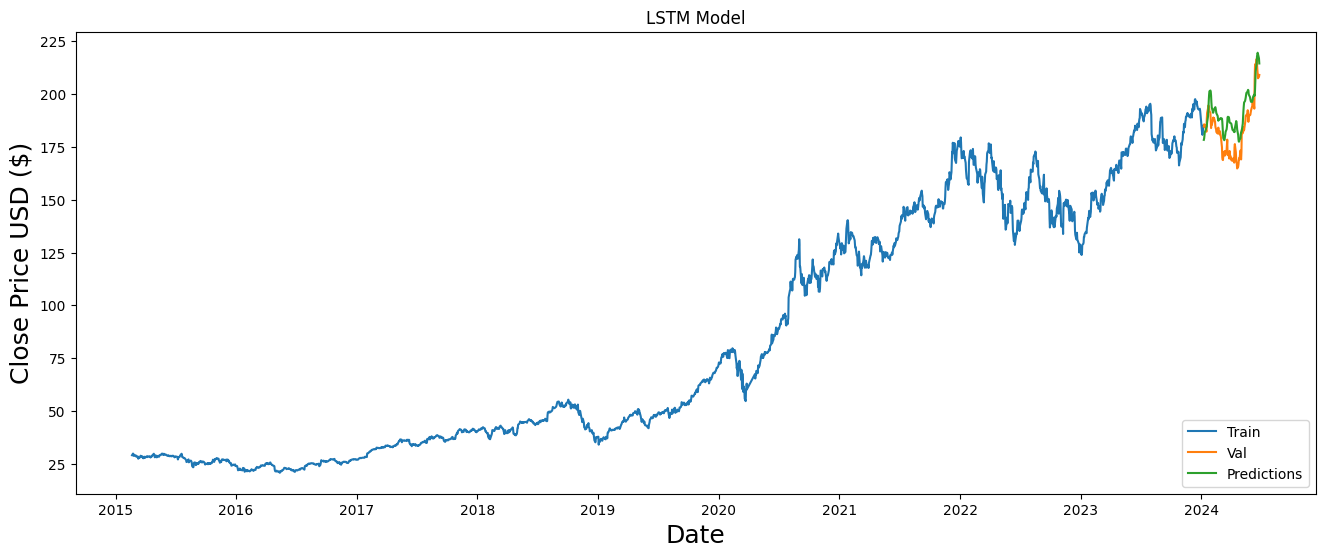

            target_ticker  tech_index        RSI  MACD Signal  MACD Histogram  \
Date                                                                            
2024-01-09     184.653595  188.397827  40.633710    -0.097436       -1.498921   
2024-01-10     185.700836  190.002365  43.357416    -0.396663       -1.196910   
2024-01-11     185.102417  190.969070  42.166899    -0.641524       -0.979445   
2024-01-12     185.431549  191.586975  43.092431    -0.832760       -0.764944   
2024-01-16     183.147568  192.065338  38.489218    -1.014902       -0.728566   
...                   ...         ...        ...          ...             ...   
2024-06-18     214.289993  231.004745  73.634787     6.523496        1.660152   
2024-06-20     209.679993  228.409302  65.265105     6.794248        1.083007   
2024-06-21     207.490005  228.009995  61.678489     6.909945        0.462789   
2024-06-24     208.139999  222.419998  62.340000     6.917013        0.028272   
2024-06-25     209.070007  2

In [18]:
# Initialize lists to store metrics for each model
rmse_values = []
r2_values = []
model_names = ['LSTM', 'ARIMA', 'Prophet']

# -------------------------------------
# LSTM Model
# -------------------------------------

# Prepare the data
dataset = cleaned_data.values
training_data_len = int(np.ceil(len(dataset) * 0.95))

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Create training data
train_data = scaled_data[:training_data_len]
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i])
    y_train.append(train_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
num_features = x_train.shape[2]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], num_features))

# Build and train the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
    LSTM(64, return_sequences=False),
    Dense(25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Create testing data
test_data = scaled_data[training_data_len - 60:]
x_test = [test_data[i-60:i] for i in range(60, len(test_data))]
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], num_features))

# Make predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], num_features-1)))))[:, 0]

# Calculate RMSE
y_test = dataset[training_data_len:, 0]
rmse_lstm = np.sqrt(np.mean((predictions - y_test) ** 2))
r2_lstm = r2_score(y_test, predictions)
print(f'LSTM RMSE: {rmse_lstm}')
print(f'LSTM R^2: {r2_lstm}')

# Store metrics
rmse_values.append(rmse_lstm)
r2_values.append(r2_lstm)

# Plot the results
train = cleaned_data[:training_data_len]
valid = cleaned_data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,6))
plt.title('LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['target_ticker'])
plt.plot(valid[['target_ticker', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

# Display the actual and predicted prices
print(valid)

### Step 7: Forecast ARIMA Model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
<ipython-input-19-b9862e1a380d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

ARIMA RMSE: 2.8236808788410106
ARIMA R^2: 0.9471277144402739


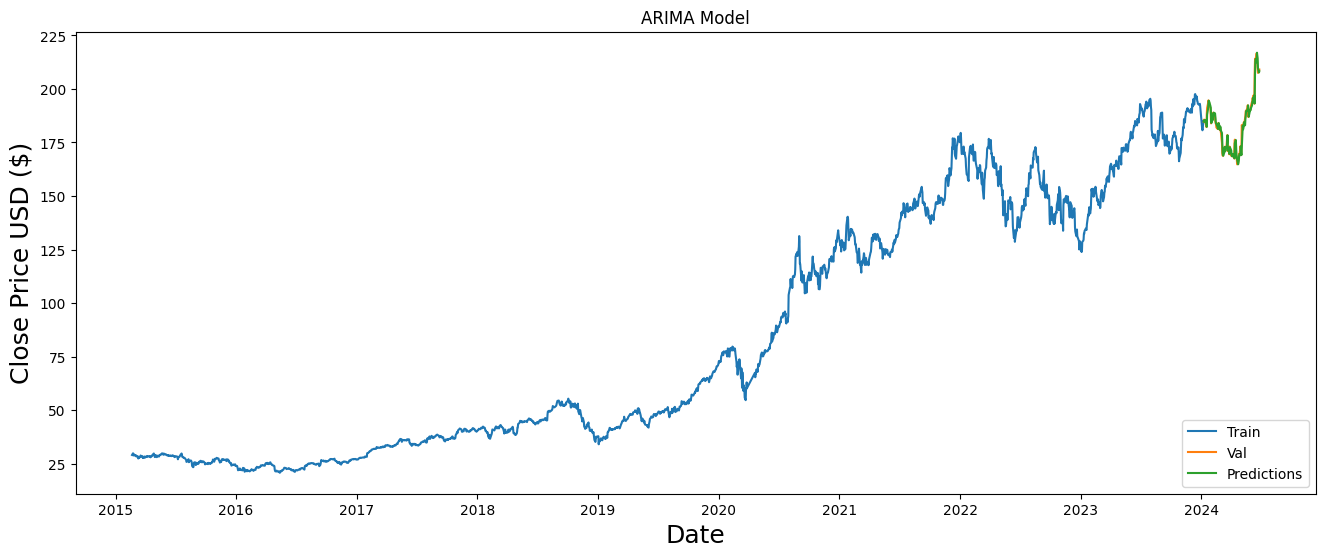

            target_ticker  tech_index        RSI  MACD Signal  MACD Histogram  \
Date                                                                            
2024-01-09     184.653595  188.397827  40.633710    -0.097436       -1.498921   
2024-01-10     185.700836  190.002365  43.357416    -0.396663       -1.196910   
2024-01-11     185.102417  190.969070  42.166899    -0.641524       -0.979445   
2024-01-12     185.431549  191.586975  43.092431    -0.832760       -0.764944   
2024-01-16     183.147568  192.065338  38.489218    -1.014902       -0.728566   
...                   ...         ...        ...          ...             ...   
2024-06-18     214.289993  231.004745  73.634787     6.523496        1.660152   
2024-06-20     209.679993  228.409302  65.265105     6.794248        1.083007   
2024-06-21     207.490005  228.009995  61.678489     6.909945        0.462789   
2024-06-24     208.139999  222.419998  62.340000     6.917013        0.028272   
2024-06-25     209.070007  2

In [19]:
# -------------------------------------
# ARIMA Model
# -------------------------------------

# Split the data into training and testing sets
training_data_len = int(np.ceil(len(cleaned_data) * 0.95))
train_data = cleaned_data.iloc[:training_data_len]
test_data = cleaned_data.iloc[training_data_len:]

# Train the ARIMA model
model = ARIMA(train_data['target_ticker'], order=(5,1,0))
model_fit = model.fit()

# Make predictions recursively
predictions = []
history = list(train_data['target_ticker'])
for t in range(len(test_data)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(test_data['target_ticker'].iloc[t])

# Add predictions to the test data
test_data['Predictions'] = predictions

# Calculate RMSE
rmse_arima = np.sqrt(mean_squared_error(test_data['target_ticker'], test_data['Predictions']))
r2_arima = r2_score(test_data['target_ticker'], test_data['Predictions'])
print(f'ARIMA RMSE: {rmse_arima}')
print(f'ARIMA R^2: {r2_arima}')

# Store metrics
rmse_values.append(rmse_arima)
r2_values.append(r2_arima)

# Plot the results
plt.figure(figsize=(16,6))
plt.title('ARIMA Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_data['target_ticker'], label='Train')
plt.plot(test_data['target_ticker'], label='Val')
plt.plot(test_data['Predictions'], label='Predictions')
plt.legend(loc='lower right')
plt.show()

# Display the actual and predicted prices
print(test_data)

### Step 8: Forecast Prophet Model

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzlpl86ht/w4l776zu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzlpl86ht/rxi4jj1q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43491', 'data', 'file=/tmp/tmpzlpl86ht/w4l776zu.json', 'init=/tmp/tmpzlpl86ht/rxi4jj1q.json', 'output', 'file=/tmp/tmpzlpl86ht/prophet_model2wquv8to/prophet_model-20240810132559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:26:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet RMSE: 7.096009151532978
Prophet R^2: 0.9857369110268964


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


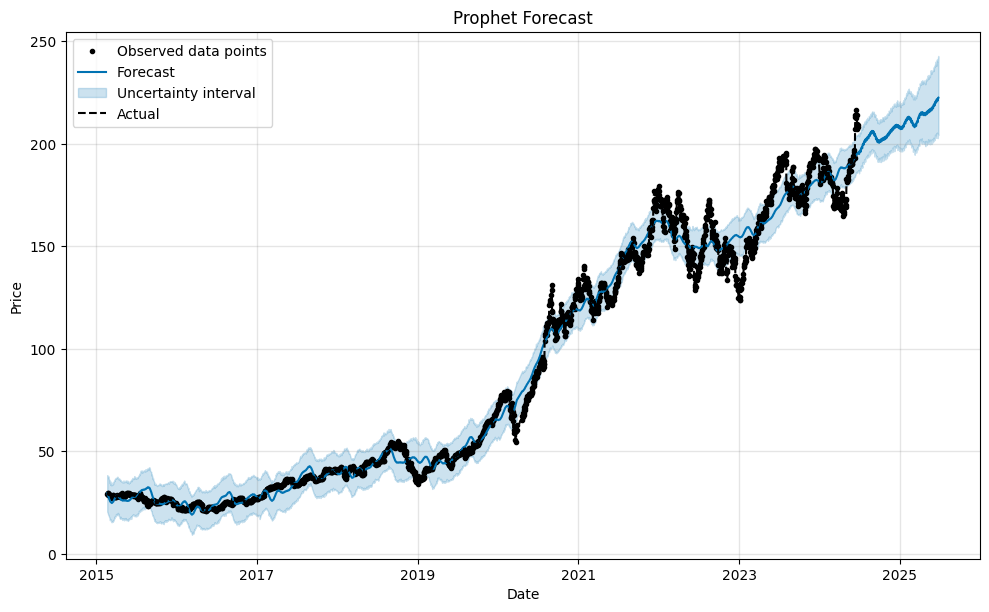

In [20]:
# -------------------------------------
# Prophet Model
# -------------------------------------

# Prepare data for Prophet
def prepare_prophet_data(df):
    df = df.reset_index()
    df = df.rename(columns={'Date': 'ds', 'target_ticker': 'y'})
    return df

# Fit Prophet model
df_prophet = prepare_prophet_data(cleaned_data)
model_prophet = Prophet()
model_prophet.fit(df_prophet)

# Make predictions
forecast = model_prophet.make_future_dataframe(periods=365)
forecast = model_prophet.predict(forecast)

# Extract actual and predicted values for error calculation
actual_values = df_prophet['y'].values
forecast_values = forecast['yhat'][:len(df_prophet)].values

# Calculate RMSE
rmse_prophet = np.sqrt(mean_squared_error(actual_values, forecast_values))
r2_prophet = r2_score(actual_values, forecast_values)
print(f'Prophet RMSE: {rmse_prophet}')
print(f'Prophet R^2: {r2_prophet}')

# Store metrics
rmse_values.append(rmse_prophet)
r2_values.append(r2_prophet)

# Plot the results
def plot_prophet_results(model, forecast, actual_df):
    """
    Plot the forecast results along with historical data.
    """
    fig = model.plot(forecast)
    plt.title('Prophet Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')

    # Add actual data to the plot
    plt.plot(actual_df['ds'], actual_df['y'], label='Actual', color='black', linestyle='--')
    plt.legend()
    plt.show()

plot_prophet_results(model_prophet, forecast, df_prophet)


In [21]:
# -------------------------------------
# Summary of Model Performance
# -------------------------------------

# Create a DataFrame for summary
summary_df = pd.DataFrame({
    'Model': model_names,
    'RMSE': rmse_values,
    'R^2': r2_values
})

# Display the summary
print("\nSummary of Model Performance:")
print(summary_df)


Summary of Model Performance:
     Model       RMSE       R^2
0     LSTM  10.150903  0.316708
1    ARIMA   2.823681  0.947128
2  Prophet   7.096009  0.985737
